1000 Iterations per layer

3 Layers

3x3 convolutions (32 per layer)

"Complete" graph

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from numba import jit
import time

def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

def conv2d(x, W, name):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME', name=name)

def max_pool_2x2(x, name):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME', name=name)

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def Layer1(num_filters,iters = 100):
    t0 = time.time()
    with tf.Graph().as_default() as g:
        x = tf.placeholder(tf.float32, shape=[None, 784])
        D0 = tf.reshape(x, [-1,28,28,1])
        y = tf.placeholder(tf.float32, shape=[None, 10])
        dropout = tf.placeholder(tf.float32)
        
        # Conv1
        W_conv1 = weight_variable([3,3,1,num_filters], "W_conv1")
        b_conv1 = bias_variable([num_filters], "b_conv1")
        h_conv1 = tf.nn.relu(conv2d(D0, W_conv1, "h_conv1") + b_conv1)
        h_conv1_drop = tf.nn.dropout(h_conv1, dropout)

        # FC
        fc1_flat = tf.contrib.layers.flatten(h_conv1_drop)
        
        W_fc1 = weight_variable([int(fc1_flat.get_shape()[1]), 10], "W_fc1")
        b_fc1 = bias_variable([10], "b_fc1")

        output = tf.matmul(fc1_flat, W_fc1) + b_fc1

        cross_entropy = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=output))
        train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
        correct_prediction = tf.equal(tf.argmax(output,1), tf.argmax(y,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    with tf.Session( graph = g) as sess:
        sess.run(tf.global_variables_initializer())
        t1 = time.time()
        Initialize_time = t1-t0
        before_test = []
        after_test = []
        test_accs = []
        for i in tqdm_notebook(range(iters), desc="Layer1"):
            if i%100 == 0:
                before_test.append(time.time())
                test_batch = mnist.test.next_batch(1000)
                test_accuracy = accuracy.eval(feed_dict={x:test_batch[0], y: test_batch[1], dropout: 1.0})
                test_accs.append(test_accuracy)
                print("step %d, test accuracy %g"%(i, test_accuracy))
                after_test.append(time.time())
            batch = mnist.train.next_batch(50)    
            sess.run(train_step, feed_dict={x: batch[0], y: batch[1], dropout: 0.5})
            

        print "Final test accuracy %g"%sess.run(accuracy, feed_dict={
            x: mnist.test.images, y: mnist.test.labels, dropout: 1.0})

        return sess.run([W_conv1, b_conv1, W_fc1, b_fc1]),test_accs,before_test,after_test,Initialize_time

In [4]:
def Layer2(Wconv, bconv, Wfc, bfc, num_filters,iters = 100):
    t0=time.time()
    
    with tf.Graph().as_default() as g:
        x = tf.placeholder(tf.float32, shape=[None, 784])
        D0 = tf.reshape(x, [-1,28,28,1])
        y = tf.placeholder(tf.float32, shape=[None, 10])
        dropout = tf.placeholder(tf.float32)
                
        # Pass Through
        D1 = tf.nn.relu(conv2d(D0, Wconv, 'pass_through1') + bconv)
        D_concat = tf.concat([D0, D1], axis=3)
        
        # Conv2
        W_conv2 = weight_variable([3,3,int(D_concat.get_shape()[3]), num_filters], "W_conv2")
        b_conv2 = bias_variable([num_filters], "b_conv2")
        h_conv2 = tf.nn.relu(conv2d(D_concat, W_conv2, "h_conv2") + b_conv2)
        h_conv2_drop = tf.nn.dropout(h_conv2, dropout)
        
        # FC
        fc2_flat_1 = tf.contrib.layers.flatten(h_conv2_drop)
        fc2_flat_2 = tf.contrib.layers.flatten(D1)
                   
        fc2_flat = tf.concat([fc2_flat_1,fc2_flat_2], axis=1)
        
        n = int(fc2_flat.get_shape()[1])
        
        W_fc2 = np.zeros((n, 10)).astype(np.float32)
        W_fc2[-Wfc.shape[0]:, :] = Wfc 
        W_fc2 = tf.Variable(W_fc2)
        
        b_fc2 = tf.Variable(bfc)
        
        output = tf.matmul(fc2_flat, W_fc2) + b_fc2

        cross_entropy = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=output))
        train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
        correct_prediction = tf.equal(tf.argmax(output,1), tf.argmax(y,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
    with tf.Session( graph = g) as sess:
        sess.run(tf.global_variables_initializer())
        t1 = time.time()
        Initialize_time = t1-t0
        before_test = []
        after_test = []
        test_accs = []
        for i in tqdm_notebook(range(iters), desc="Layer2"):
            if i%100 == 0:
                before_test.append(time.time())
                test_batch = mnist.test.next_batch(1000)
                test_accuracy = accuracy.eval(feed_dict={x:test_batch[0], y: test_batch[1], dropout: 1.0})
                test_accs.append(test_accuracy)
                print("step %d, test accuracy %g"%(i, test_accuracy))
                after_test.append(time.time())
            batch = mnist.train.next_batch(50)    
            sess.run(train_step, feed_dict={x: batch[0], y: batch[1], dropout: 0.5})
            

        print "Final test accuracy %g"%sess.run(accuracy, feed_dict={
            x: mnist.test.images, y: mnist.test.labels, dropout: 1.0})
        return sess.run([W_conv2, b_conv2, W_fc2, b_fc2]),test_accs,before_test,after_test,Initialize_time


In [5]:
def Layer3(Wconv1, Wconv2, bconv1, bconv2, Wfc, bfc, num_filters,iters = 100):
    t0=time.time()
    with tf.Graph().as_default() as g:
        x = tf.placeholder(tf.float32, shape=[None, 784])
        D0 = tf.reshape(x, [-1,28,28,1])
        y = tf.placeholder(tf.float32, shape=[None, 10])
        dropout = tf.placeholder(tf.float32)
        
        # Pass Through
        D1 = tf.nn.relu(conv2d(D0, Wconv1, 'pass_through1') + bconv1)
        D2 = tf.nn.relu(conv2d(tf.concat([D0, D1], axis=3), Wconv2, 'pass_through2') + bconv2)
        D_concat = tf.concat([D0,D1,D2], axis=3)
        
        # Conv3
        W_conv3 = weight_variable([3,3,int(D_concat.get_shape()[3]), num_filters], "W_conv3")
        b_conv3 = bias_variable([num_filters], "b_conv3")
        h_conv3 = tf.nn.relu(conv2d(D_concat, W_conv3, "h_conv3") + b_conv3)
        h_conv3_drop = tf.nn.dropout(h_conv3, dropout)
        
        # FC
        fc3_flat_1 = tf.contrib.layers.flatten(h_conv3_drop)
        fc3_flat_2 = tf.contrib.layers.flatten(D2)
        fc3_flat_3 = tf.contrib.layers.flatten(D1)
            
        fc3_flat = tf.concat([fc3_flat_1, fc3_flat_2,fc3_flat_3], axis=1)
        
        n = int(fc3_flat.get_shape()[1])
        
        W_fc3 = np.zeros((n, 10)).astype(np.float32)
        W_fc3[-Wfc.shape[0]:, :] = Wfc 
        W_fc3 = tf.Variable(W_fc3)
        
        b_fc3 = tf.Variable(bfc)
        
        output = tf.matmul(fc3_flat, W_fc3) + b_fc3
        
        cross_entropy = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=output))
        train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
        correct_prediction = tf.equal(tf.argmax(output,1), tf.argmax(y,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    with tf.Session( graph = g) as sess:
        sess.run(tf.global_variables_initializer())
        t1 = time.time()
        Initialize_time = t1-t0
        before_test = []
        after_test = []
        test_accs = []
        for i in tqdm_notebook(range(iters), desc="Layer2"):
            if i%100 == 0:
                before_test.append(time.time())
                test_batch = mnist.test.next_batch(1000)
                test_accuracy = accuracy.eval(feed_dict={x:test_batch[0], y: test_batch[1], dropout: 1.0})
                test_accs.append(test_accuracy)
                print("step %d, test accuracy %g"%(i, test_accuracy))
                after_test.append(time.time())
            batch = mnist.train.next_batch(50)    
            sess.run(train_step, feed_dict={x: batch[0], y: batch[1], dropout: 0.5})
            

        print "Final test accuracy %g"%sess.run(accuracy, feed_dict={
            x: mnist.test.images, y: mnist.test.labels, dropout: 1.0})

        return sess.run([W_conv3, b_conv3, W_fc3, b_fc3]),test_accs,before_test,after_test,Initialize_time



In [6]:
test_accs = []
before_test = []
after_test = []
Initialize_time = []

In [7]:
a = Layer1(4,iters = 1000)
D0_Wconv, D0_bconv, D0_Wfc, D0_bfc = a[0]
test_accs += a[1]
before_test += a[2]
after_test += a[3]
Initialize_time.append(a[4])

step 0, test accuracy 0.1
step 100, test accuracy 0.259
step 200, test accuracy 0.391
step 300, test accuracy 0.518
step 400, test accuracy 0.62
step 500, test accuracy 0.782
step 600, test accuracy 0.778
step 700, test accuracy 0.82
step 800, test accuracy 0.882
step 900, test accuracy 0.819

Final test accuracy 0.833


In [8]:
b = Layer2(D0_Wconv, D0_bconv, D0_Wfc, D0_bfc,4,iters=1000)
D1_Wconv, D1_bconv, D1_Wfc, D1_bfc = b[0]
test_accs += b[1]
before_test += b[2]
after_test += b[3]
Initialize_time.append(b[4])

step 0, test accuracy 0.851
step 100, test accuracy 0.843
step 200, test accuracy 0.845
step 300, test accuracy 0.859
step 400, test accuracy 0.877
step 500, test accuracy 0.872
step 600, test accuracy 0.886
step 700, test accuracy 0.903
step 800, test accuracy 0.88
step 900, test accuracy 0.888

Final test accuracy 0.9017


In [9]:
c = Layer3(D0_Wconv, D1_Wconv, D0_bconv, D1_bconv, D1_Wfc, D1_bfc,4,iters = 1000)
D2_Wconv, D2_bconv, D2_Wfc, D2_bfc = c[0]
test_accs += c[1]
before_test += c[2]
after_test += c[3]
Initialize_time.append(c[4])

step 0, test accuracy 0.905
step 100, test accuracy 0.899
step 200, test accuracy 0.904
step 300, test accuracy 0.897
step 400, test accuracy 0.92
step 500, test accuracy 0.92
step 600, test accuracy 0.915
step 700, test accuracy 0.921
step 800, test accuracy 0.913
step 900, test accuracy 0.919

Final test accuracy 0.9224


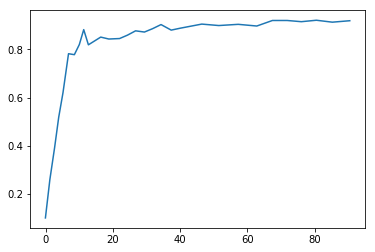

In [10]:
testing_time = np.array(before_test)-np.array(after_test)
time_since_start = np.array(before_test)+np.array(np.cumsum(testing_time))-np.array([before_test[0]])
plt.plot(time_since_start,test_accs)
plt.show()